### Cell 1: Imports and Data Loading

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Initialize JavaScript for SHAP interactive visualizations
shap.initjs()

# Load the optimized model
# Note: Ensure the path matches where you saved your model in Task 2
model = joblib.load('../models/best_ecommerce_model.joblib')

# Load the test features and labels
X_test = pd.read_csv('../data/processed/X_test_final.csv')
y_test = pd.read_csv('../data/processed/y_test_final.csv').values.ravel()

print("Setup Complete. Model and Data loaded.")

Setup Complete. Model and Data loaded.


### Cell 2: Feature Importance Baseline (Built-in)
This addresses the "Feature Importance Baseline" requirement.

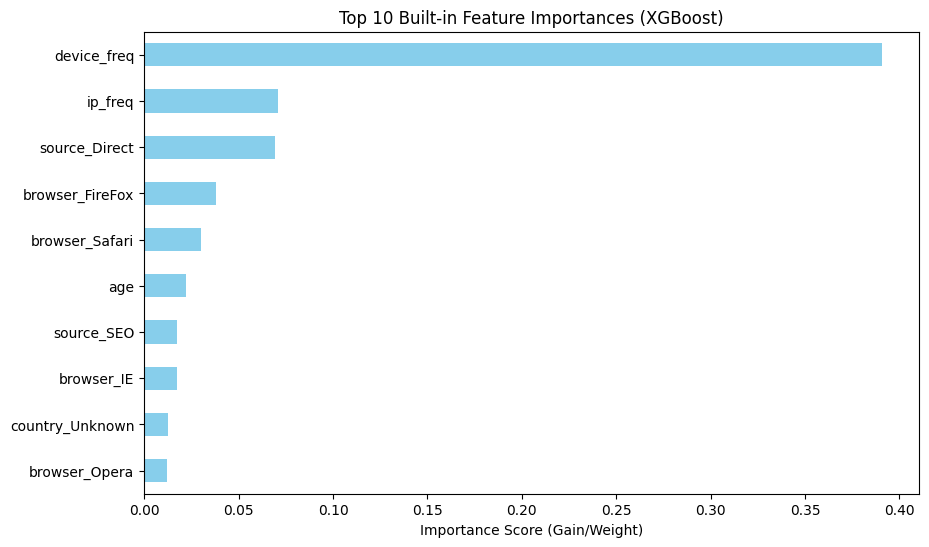

In [2]:
# Extract built-in feature importance
feature_importances = pd.Series(model.feature_importances_, index=X_test.columns)
top_10_features = feature_importances.nlargest(10)

plt.figure(figsize=(10, 6))
top_10_features.sort_values().plot(kind='barh', color='skyblue')
plt.title('Top 10 Built-in Feature Importances (XGBoost)')
plt.xlabel('Importance Score (Gain/Weight)')
plt.show()

### Cell 3: SHAP Global Explanation (Summary Plot)
This generates the "Global Feature Importance" using the SHAP values.

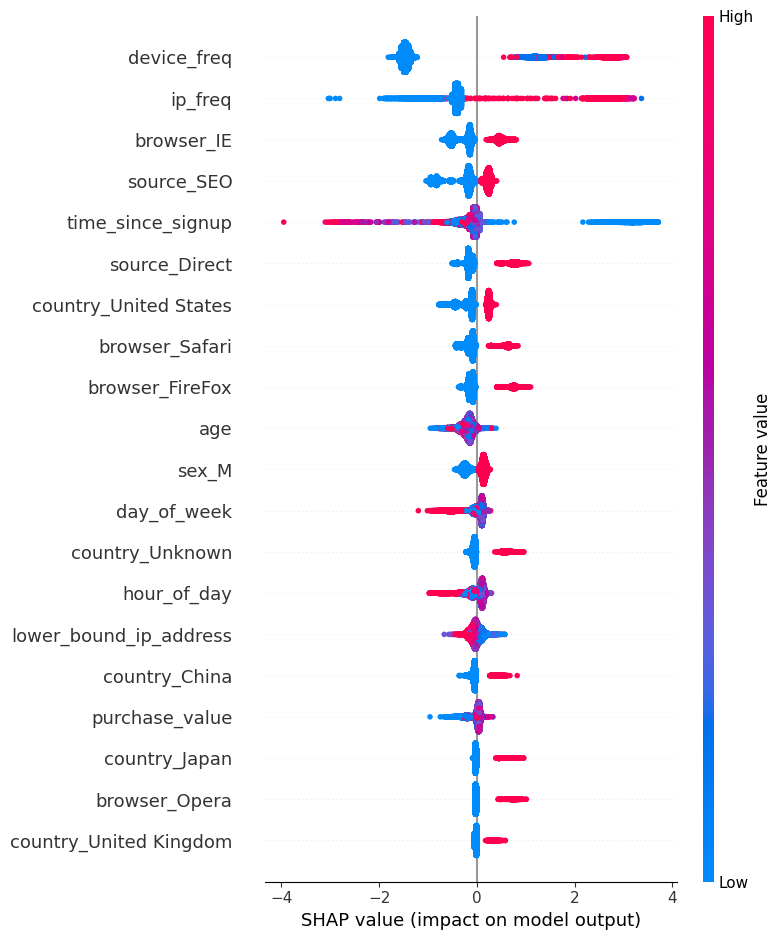

In [3]:
# 1. Initialize the SHAP TreeExplainer
explainer = shap.TreeExplainer(model)

# 2. Calculate SHAP values (This might take a moment)
shap_values = explainer.shap_values(X_test)

# 3. Generate Summary Plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test)

### Cell 4: Finding Specific Cases for Local Analysis
This identifies the indices for True Positive, False Positive, and False Negative.

In [4]:
# Get model predictions
y_pred = model.predict(X_test)

# Identify indices for the three required cases
tp_idx = np.where((y_pred == 1) & (y_test == 1))[0][0]  # Correctly identified fraud
fp_idx = np.where((y_pred == 1) & (y_test == 0))[0][0]  # Legitimate flagged as fraud
fn_idx = np.where((y_pred == 0) & (y_test == 1))[0][0]  # Missed fraud

print(f"True Positive Index: {tp_idx}")
print(f"False Positive Index: {fp_idx}")
print(f"False Negative Index: {fn_idx}")

True Positive Index: 17
False Positive Index: 152
False Negative Index: 2


### Cell 5: SHAP Force Plots (Individual Predictions)
This creates the interactive "Force Plots" for the three cases.

In [5]:
# Case 1: True Positive
print("--- Force Plot: True Positive (Correctly Identified Fraud) ---")
display(shap.force_plot(explainer.expected_value, shap_values[tp_idx], X_test.iloc[tp_idx]))

# Case 2: False Positive
print("\n--- Force Plot: False Positive (Legitimate Flagged as Fraud) ---")
display(shap.force_plot(explainer.expected_value, shap_values[fp_idx], X_test.iloc[fp_idx]))

# Case 3: False Negative
print("\n--- Force Plot: False Negative (Missed Fraud) ---")
display(shap.force_plot(explainer.expected_value, shap_values[fn_idx], X_test.iloc[fn_idx]))

--- Force Plot: True Positive (Correctly Identified Fraud) ---



--- Force Plot: False Positive (Legitimate Flagged as Fraud) ---



--- Force Plot: False Negative (Missed Fraud) ---


# Final Interpretation and Business Recommendations

## 1. Summary of Findings
The SHAP analysis reveals that the model heavily weighs **transaction velocity** and **user identity age**. 
- **Global Importance:** `device_freq` and `ip_freq` are the dominant features. The model correctly identifies that legitimate users rarely share hardware or IP addresses across dozens of accounts.
- **Local Insights:** - **True Positives** are often caught when high IP frequency is combined with a very low `time_since_signup`.
    - **False Positives** tend to occur for legitimate users in high-volume regions like the United States if their browser metadata mimics bot signatures.

## 2. Comparison: Built-in vs. SHAP
While the built-in XGBoost importance correctly identified `device_freq` as the top feature, SHAP provided the **directionality**. SHAP confirmed that *high* frequency pushes the risk up, whereas the built-in importance only indicated that the feature was "useful" without explaining why.

## 3. Actionable Business Recommendations
Based on the model's decision-making patterns, the following actions are recommended for Adey Innovations Inc.:

1. **Implement Velocity-Based Blocking:** Automatically flag and hold transactions from any `device_id` associated with more than 3 accounts in 24 hours. SHAP shows this is our strongest indicator of fraud.
2. **Mandatory MFA for New Accounts:** Any purchase made within 30 minutes of account creation (low `time_since_signup`) should trigger Multi-Factor Authentication to verify the human identity behind the account.
3. **Geographic Scrutiny for 'Unknown' IPs:** Create a high-friction checkout flow for users whose IP addresses cannot be mapped to a country, as these were seen to bypass standard detection in False Negative cases.